# Deep-learning TP1: 

Le but de ce TP1 est d'acquérir les bases nécessaires à la compréhension des réseaux de neurones à partir d'un modèle simple de type Softmax. La tâche d'apprentissage consiste à classifier les images (28 par 28 pixels) de la base MNIST (http://yann.lecun.com/exdb/mnist/) en 10 catégories représentant les chiffres 0-9.

Le TP2 consistera à généraliser les concepts de ce TP1 à un réseau de neurones multi-couches.

## Téléchargement de la base d'entraînement

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

if("mnist.pkl.gz" not in os.listdir(".")):
    print('download mnist data')
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

## Chargement de la base en mémoire

In [2]:
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_mnist()

Vous pouvez visualiser les différents caractères en changeant l'identifiant de l'image

label: 2


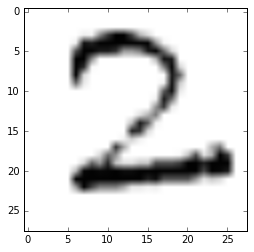

In [3]:
img_id = 903
plt.imshow(train_set[0][img_id].reshape(28,28),cmap='Greys')
print("label: " + str(train_set[1][img_id]))

Question 1: Donner les caractéristiques de la base d'apprentissage train_set

In [4]:
def getDimDataset(train_set):
    y = set(train_set[1])
    n_training =  len(train_set[0])
    n_feature = len(train_set[0][1])
    n_label = len(y)
    return n_training, n_feature, n_label

In [5]:
n_training, n_feature, n_label = getDimDataset(train_set)

In [6]:
print n_training 
print n_feature
print n_label

50000
784
10


## Création du modèle

In [7]:
def init(n_feature,n_label):
    sigma = 1.
    W = np.random.normal(loc=0.0, scale=sigma/np.sqrt(n_feature), size=(n_label,n_feature))
    b = np.zeros((W.shape[0],1))
    return W,b

In [8]:
W, b = init(n_feature,n_label)

Question 2: Donner les dimensions de W et b ainsi que le nombre total de paramètres du modèle

In [9]:
def printInfo(W,b):
    print("W dimensions: " + str(W.shape))
    print("b dimensions: " + str(b.shape))
    print("Number of parameters: " + str(W.shape[0]*W.shape[1]+b.shape[0]))

In [10]:
printInfo(W,b)

W dimensions: (10L, 784L)
b dimensions: (10L, 1L)
Number of parameters: 7850


Question 3: Implémenter la fonction forward $$z_j = \sum_{i \rightarrow j} W_{ij} x_i + b_j$$ où $x_i$ est un pixel de l'image, $W_{ij}$ est la valeur associée à l'arête reliant les unités $i$ et $j$ et $b_j$ est le bias associé à l'unité $j$

In [11]:
def forward(W,b,X):
    """
        Perform the forward propagation
        :param W: the weights
        :param b: the bias
        :param X: the input (minibatch_size x n_input)
        :type W: ndarray
        :type B: ndarray
        :type X: ndarray
        :return: the transformed values
        :rtype: ndarray
    """
    z = np.dot(W,X.T)+ b
    return z

In [12]:
z = forward(W,b,train_set[0])
print z.shape

(10L, 50000L)


Question 4: Implémenter la fonction softmax $$ \sigma_i = P(t=i|x,W,b) = \frac{\exp{z_i}}{\sum_k \exp{z_k}}$$

In [13]:
def softmax(z):
    """
        Perform the softmax transformation to the pre-activation values
        :param z: the pre-activation values
        :type z: ndarray
        :return: the activation values
        :rtype: ndarray
    """
    return np.exp(z-np.max(z,0))/np.sum(np.exp(z-np.max(z,0)),axis = 0) 

Optionnel: Vérifier que votre implémentation de softmax soit numériquement stable (cf. http://ufldl.stanford.edu/wiki/index.php/Exercise:Softmax_Regression)

In [14]:
# Example for testing the numerical stability of softmax
# It should return [1., 0. ,0.], not [nan, 0., 0.]
F = softmax(z)
print F[:,0].sum()


1.0


Question 5: Implémenter le calcul du gradient de l'erreur par rapport à $z_i$:
$$\delta z_i = \sigma_i - 1_{i=l}$$
où $l$ est l'étiquette associée à la donnée courante.

In [15]:
def gradient_out(out, one_hot_batch):
    """
    compute the gradient w.r.t. the pre-activation values of the softmax z_i
    :param out: the softmax values
    :type out: ndarray
    :param one_hot_batch: the one-hot representation of the labels
    :type one_hot_batch: ndarray
    :return: the gradient w.r.t. z
    :rtype: ndarray
    """
    return out-one_hot_batch

Question 6: Implémenter la fonction du calcul de gradient par rapport aux paramètres: $$\delta W_{ij} = \delta z_j x_i$$  $$\delta b_{j} = \delta z_j$$ où $\delta W_{ij}$ est la composante du gradient associée à l'arête reliant les unités $i$ et $j$, $\delta b_{j}$ est la composante du gradient associée au bias de l'unité $j$, $\delta z_j$ est le gradient de l'erreur par rapport à l'unité $j$ et $x_i$ est la valeur d'activation de l'unité $i$.

In [16]:
def gradient(derror, X):
    """
        Compute the gradient w.r.t. the parameters
        :param derror: the gradient w.r.t. z
        :param X: the input (minibatch_size x n_input)
        :param minibatch_size: the minibatch size
        :type derror: ndarray
        :type minibatch: ndarray
        :type minibatch_size: unsigned
        :return: the gradient w.r.t. the parameters
        :rtype: ndarray, ndarray
    """
    minibatch_size = X.shape[0]
    grad_w = derror.dot(X)/minibatch_size
    grad_b = np.sum(derror,axis=1).reshape(-1,1)/minibatch_size
    return grad_w,grad_b

Question 7: Implémenter la fonction de mise à jour des paramètres $$p = p - \eta \delta p$$ où $p$ est un paramètre du modèle et $\delta p$ la composante du gradient associée à p.

In [17]:
def update(eta, W, b, grad_w, grad_b):
    """
        Update the parameters with an update rule
        :param eta: the step-size
        :param W: the weights
        :param b: the bias
        :param grad_w: the gradient w.r.t. the weights
        :param grad_b: the gradient w.r.t. the bias
        :type eta: float
        :type W: ndarray
        :type b: ndarray
        :type grad_w: ndarray
        :type grad_b: ndarray
        :return: the updated parameters
        :rtype: ndarray, ndarray
    """
    W = W - eta*grad_w
    b = b - eta*grad_b
    return W,b

## Algorithme d'apprentissage

In [18]:
import math,time
from IPython.display import clear_output
from _aux import *

def training(eta = .0001, n_epoch = 100, verbose = False): 
    # Data structures for plotting
    g_i = []
    g_train_loss=[]
    g_train_acc=[]
    g_valid_loss=[]
    g_valid_acc=[]

    n_training, n_feature, n_label = getDimDataset(train_set)

    # SGD parameters
    batch_size = 500
    n_batch = int(math.ceil(float(n_training)/batch_size))

    cumul_time = 0.

    # Initialize the model parameters
    W,b = init(n_feature,n_label)
    printInfo(W,b)

    # Convert the labels to one-hot vector
    one_hot = np.zeros((n_label,n_training))
    one_hot[train_set[1],np.arange(n_training)]=1.

    for i in range(n_epoch):
        for j in range(n_batch):

            ### Mini-batch creation
            minibatch, one_hot_batch, minibatch_size = getMiniBatch(j, batch_size, train_set, one_hot)

            prev_time = time.clock()

            ### Forward propagation
            Z = forward(W,b,minibatch)

            ### Compute the softmax
            out = softmax(Z)

            ### Compute the gradient at the top layer
            derror = gradient_out(out,one_hot_batch)

            ### Compute the gradient w.r.t. parameters
            grad_w,grad_b = gradient(derror, minibatch)

            ### Update the parameters
            W,b = update(eta, W, b, grad_w, grad_b)

            curr_time = time.clock()
            cumul_time += curr_time - prev_time

        ### Training accuracy
        train_loss, train_acc = computeLoss(W, b, train_set[0], train_set[1],softmax) 

        ### Valid accuracy
        valid_loss, valid_acc = computeLoss(W, b, valid_set[0], valid_set[1],softmax) 

        g_i = np.append(g_i, i)
        g_train_loss = np.append(g_train_loss, train_loss)
        g_train_acc = np.append(g_train_acc, train_acc)
        g_valid_loss = np.append(g_valid_loss, valid_loss)
        g_valid_acc = np.append(g_valid_acc, valid_acc)

        result_line = str(i) + " " + str(cumul_time) + " " + str(train_loss) + " " + str(train_acc) + " " + str(valid_loss) + " " + str(valid_acc) + " " + str(eta)
        if verbose:
            print(result_line)
        
    return g_train_loss, g_train_acc, g_valid_loss, g_valid_acc

W dimensions: (10L, 784L)
b dimensions: (10L, 1L)
Number of parameters: 7850
0 1.47617232078 2.27881561989 0.12186 2.27379256362 0.1187 0.001
1 3.17366466967 2.17256004726 0.2167 2.16610371664 0.223 0.001
2 4.74707358058 2.07815716937 0.35648 2.06996869259 0.3674 0.001
3 6.40072676835 1.99231940458 0.4686 1.98226469927 0.4868 0.001
4 9.37853372426 1.91343303068 0.54526 1.90146816677 0.5642 0.001
5 12.459196071 1.84058440373 0.60342 1.82671715981 0.6215 0.001
6 14.9135100271 1.77316081395 0.64542 1.75742970801 0.6626 0.001
7 16.7896194209 1.71068503536 0.67686 1.69314723264 0.6932 0.001
8 20.5545859879 1.65274714906 0.6981 1.63347110352 0.7169 0.001
9 23.4237823522 1.59897700305 0.7135 1.57803774485 0.731 0.001
10 25.0929509197 1.54903345381 0.72606 1.52650942998 0.7449 0.001
11 27.0646371257 1.5026003134 0.73536 1.47857119159 0.7553 0.001
12 28.7400238717 1.45938477114 0.74322 1.4339298779 0.7652 0.001
13 30.3885579033 1.4191165527 0.75032 1.39231375544 0.7732 0.001
14 32.0524318035 1.

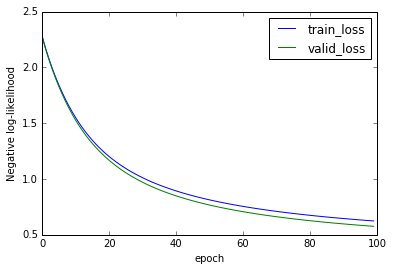

In [19]:
plt.plot(g_i,g_train_loss,label='train_loss')
plt.plot(g_i,g_valid_loss,label='valid_loss')
plt.xlabel("epoch")
plt.ylabel("Negative log-likelihood")
plt.legend()

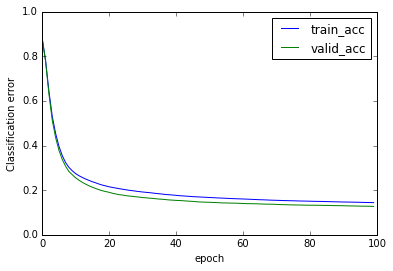

In [20]:
plt.plot(g_i,1.0-g_train_acc,label='train_acc')
plt.plot(g_i,1.0-g_valid_acc,label='valid_acc')
plt.xlabel("epoch")
plt.ylabel("Classification error")
plt.ylim([0.,1.])
plt.legend()

Question 8: Montrer, à l'aide d'une figure, l'effet du step-size (prendre $\eta$=[0.01,0.1,1.0,10.]) sur les courbes d'apprentissage

W dimensions: (10L, 784L)
b dimensions: (10L, 1L)
Number of parameters: 7850
W dimensions: (10L, 784L)
b dimensions: (10L, 1L)
Number of parameters: 7850
W dimensions: (10L, 784L)
b dimensions: (10L, 1L)
Number of parameters: 7850
W dimensions: (10L, 784L)
b dimensions: (10L, 1L)
Number of parameters: 7850
W dimensions: (10L, 784L)
b dimensions: (10L, 1L)
Number of parameters: 7850


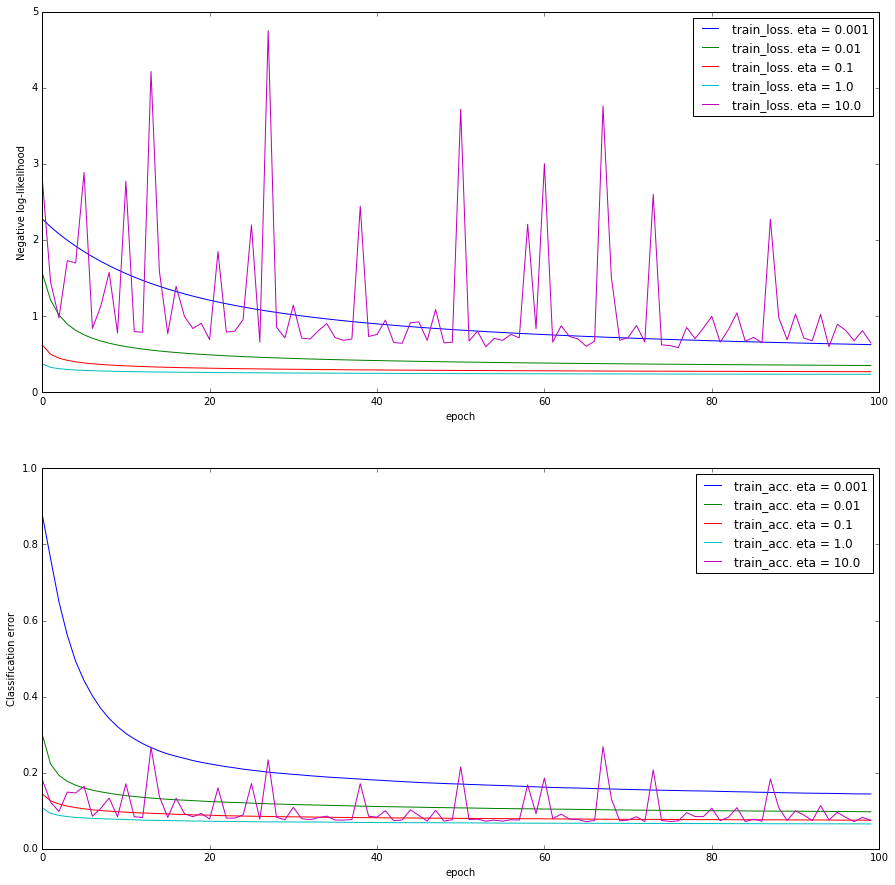

In [24]:
plt.figure(figsize = (15,15))
for eta in [.001,0.01,0.1,1.0,10.]:
    g_train_loss, g_train_acc, g_valid_loss, g_valid_acc = training(eta, 100)
    
    plt.subplot(211)
    plt.plot(g_train_loss,label='train_loss. eta = ' +str(eta))
    #plt.plot(g_i,g_valid_loss,label='valid_loss. eta = ' +str(eta))
    plt.xlabel("epoch")
    plt.ylabel("Negative log-likelihood")
    plt.legend()
    
    plt.subplot(212)
    
    plt.plot(1- g_train_acc,label='train_acc. eta = ' +str(eta))
    #plt.plot(g_i,1- g_valid_acc,label='valid_acc. eta = ' +str(eta))
    plt.xlabel("epoch")
    plt.ylabel("Classification error")
    plt.ylim([0.,1.])
    plt.legend()